In [7]:
import cv2
import os

# Read the video from specified path
vid = cv2.VideoCapture("Circles1.mp4")

try:

    # creating a folder named data
    if not os.path.exists('data'):
        os.makedirs('data')

# if not created then raise error
except OSError:
    print('Error: Creating directory of data')

# frame
i=0
currentframe = 0
frame_skip = 1
while (True):

    # reading from frame
    success, frame = vid.read()

    if success:
        # continue creating images until video remains
        name = './data/frame' + str(currentframe*frame_skip) + '.jpg'
        print('Creating...' + name)

        # writing the extracted images
        if i > frame_skip - 1:
            currentframe += 1
            cv2.imwrite(name, frame)
            i = 0
            continue
        i += 1
        # increasing counter so that it will
        # show how many frames are created
        
    else:
        break

# Release all space and windows once done
vid.release()
cv2.destroyAllWindows()

Creating..../data/frame0.jpg
Creating..../data/frame0.jpg
Creating..../data/frame1.jpg
Creating..../data/frame1.jpg
Creating..../data/frame2.jpg
Creating..../data/frame2.jpg
Creating..../data/frame3.jpg
Creating..../data/frame3.jpg
Creating..../data/frame4.jpg
Creating..../data/frame4.jpg
Creating..../data/frame5.jpg
Creating..../data/frame5.jpg
Creating..../data/frame6.jpg
Creating..../data/frame6.jpg
Creating..../data/frame7.jpg
Creating..../data/frame7.jpg
Creating..../data/frame8.jpg
Creating..../data/frame8.jpg
Creating..../data/frame9.jpg
Creating..../data/frame9.jpg
Creating..../data/frame10.jpg
Creating..../data/frame10.jpg
Creating..../data/frame11.jpg
Creating..../data/frame11.jpg
Creating..../data/frame12.jpg
Creating..../data/frame12.jpg
Creating..../data/frame13.jpg
Creating..../data/frame13.jpg
Creating..../data/frame14.jpg
Creating..../data/frame14.jpg
Creating..../data/frame15.jpg
Creating..../data/frame15.jpg
Creating..../data/frame16.jpg
Creating..../data/frame16.jpg


In [2]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib as mpl
import matplotlib.pyplot as plt

# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 5))
mpl.rc('image', cmap='gray')

In [3]:
!pip install pims
!pip install trackpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 86 kB 3.0 MB/s 
  Created wheel for pims: filename=PIMS-0.6.1-py3-none-any.whl size=82635 sha256=8c276c7f605778ab2bfa2bcde78ed1118886e9ae253f15194cfddb7768693a89
  Stored in directory: /root/.cache/pip/wheels/5c/bd/a9/9cede777cb4fcdd2ba712cdb0d0c9082aba544322eb5ad7af1
Successfully built pims
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 131 kB 5.2 MB/s 
  Created wheel for trackpy: filename=trackpy-0.5.0-py3-none-any.whl size=128767 sha256=fff56f6fa85dfe2b15b7c2fcb4155baa094b6d63c174046941a5a9c0ef9a62a8
  Stored in directory: /root/.cache/pip/wheels/f6/08/12/c940ca467827675521125cfed4a5b41dd7bb76efbbb128598d
Successfully built trackpy


In [4]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience
import os
import pims
import trackpy as tp

In [5]:
datapath = 'data'
prefix = 'frame'

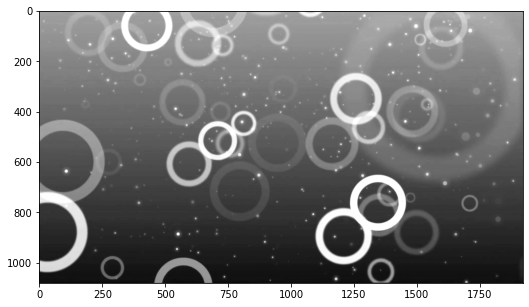

In [8]:
id_example = 4



@pims.pipeline
def gray(image):
    return image[:, :, 1]  # Take just the green channel
rawframes = gray(pims.open(os.path.join(datapath, prefix + '*.jpg')))
plt.imshow(rawframes[id_example]);

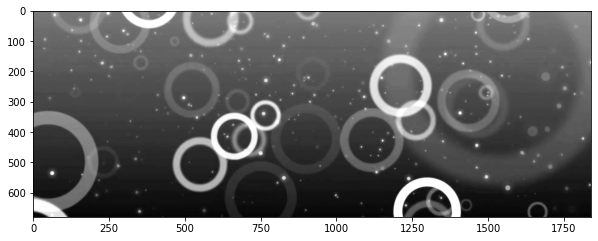

In [9]:
@pims.pipeline
def crop(img):
    """
    Crop the image to select the region of interest
    """
    x_min = 45
    x_max = -35
    y_min = 100
    y_max = -300 
    return img[y_min:y_max,x_min:x_max]

rawframes = crop(gray(pims.open(os.path.join(datapath, prefix + '*.jpg'))))
plt.imshow(rawframes[id_example]);

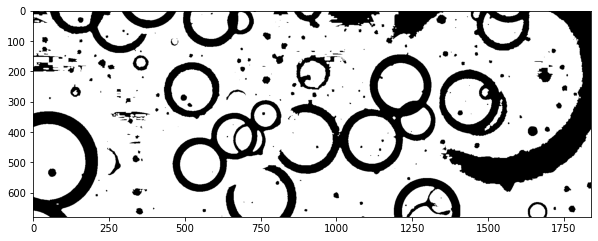

In [10]:
from scipy import ndimage
from skimage import morphology, util, filters


@pims.pipeline
def preprocess_foam(img):
    """
    Apply image processing functions to return a binary image
    """
    # Crop the pictures as for raw images.
    img = crop(img)
    # Apply thresholds
    adaptive_thresh = filters.threshold_local(img,301)
    idx = img > adaptive_thresh
    idx2 = img < adaptive_thresh
    img[idx] = 0
    img[idx2] = 255
    img = ndimage.binary_dilation(img)
    img = ndimage.binary_dilation(img)
    return util.img_as_int(img)


frames = preprocess_foam(gray(pims.open(os.path.join(datapath, prefix + '*.jpg'))))
plt.imshow(frames[id_example]);

Found 298 features


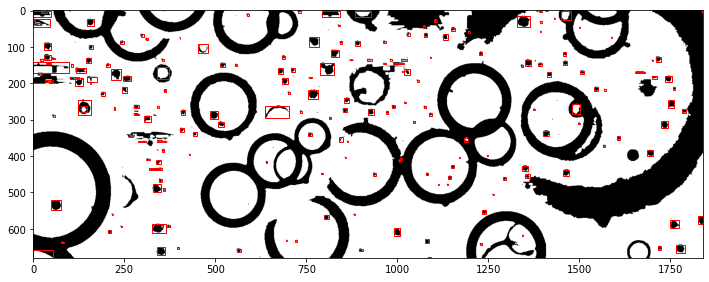

In [11]:
import skimage
import matplotlib.patches as mpatches

img_example = frames[id_example]

# Label elements on the picture
white = 255
label_image, number_of_labels = skimage.measure.label(img_example, background=white, return_num=True)
print("Found %d features"%(number_of_labels))
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 12))
ax.imshow(img_example)
for region in skimage.measure.regionprops(label_image, intensity_image=img_example):
    # Everywhere, skip small and large areas
    if region.area < 5 or region.area > 800:
        continue
    # Only black areas
    # if region.mean_intensity > 1:
    #     continue
    # On the top, skip small area with a second threshold
    # if region.centroid[0] < 260 and region.area < 80:
    #     continue
    # Draw rectangle which survived to the criterions
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=1)

    ax.add_patch(rect)

In [12]:
features = pd.DataFrame()
for num, img in enumerate(frames):
    white = 255
    label_image = skimage.measure.label(img, background=white)
    for region in skimage.measure.regionprops(label_image, intensity_image=img):
        # Everywhere, skip small and large areas
        if region.area < 5 or region.area > 800:
            continue
        # Only black areas
        if region.mean_intensity > 1:
            continue
        # On the top, skip small area with a second threshold
        if region.centroid[0] < 260 and region.area < 80: 
            continue
        # Store features which survived to the criterions
        features = features.append([{'y': region.centroid[0],
                                     'x': region.centroid[1],
                                     'frame': num,
                                     },])

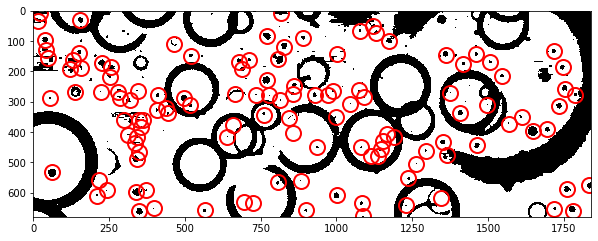

In [13]:
tp.annotate(features[features.frame==(id_example+1)], img_example);

Frame 29: 130 trajectories present.


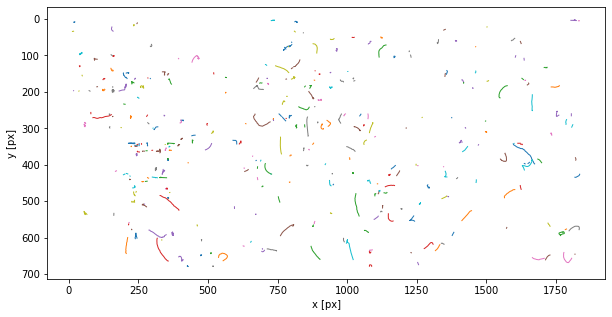

In [14]:
search_range = 11
t = tp.link_df(features, search_range, memory=5)
tp.plot_traj(t)